In [1]:
import json

import dash
import jupyterlab_dash
import dash_html_components as html
import dash_table
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from IPython import display


viewer = jupyterlab_dash.AppViewer()
app = dash.Dash(__name__)
PAGE_SIZE = 30


In [2]:
def refine_province_name(name: str) -> str:
    return " ".join([n.capitalize() for n in name.split("-")])

In [3]:
response_covid_cases_API = requests.get('https://api.apify.com/v2/key-value-stores/ZsOpZgeg7dFS1rgfM/records/LATEST')
covid_cases_data = json.loads(response_covid_cases_API.text)

In [4]:
overall_covid_cases_data = {'Infected': covid_cases_data['infected'], 'Treated': covid_cases_data['treated'],
                            'Recovered': covid_cases_data['recovered'], 'Deceased': covid_cases_data['deceased']}
detail_covid_cases_data = covid_cases_data['detail']

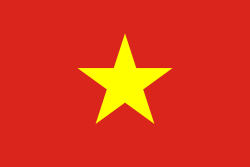

In [6]:
display.Image("./Flag_of_Vietnam.png")

In [7]:
print(f"Vietname Covid-19 information at {covid_cases_data['lastUpdatedAtSource']}")
for k, v in overall_covid_cases_data.items():
    print(k,':', v)

Vietname Covid-19 information at 2021-07-02T11:00:00.000Z
Infected : 17902
Treated : 10419
Recovered : 7395
Deceased : 84


In [10]:
provinces_API = requests.get('https://api.apify.com/v2/key-value-stores/p3nS2Q9TUn6kUOriJ/records/LATEST')
provinces_data = json.loads(provinces_API.text)['key']

In [11]:
detail_covid_cases_df = pd.DataFrame(detail_covid_cases_data)
province_df = pd.DataFrame(provinces_data)
province_df.columns = ['province_name', 'hc-key']

In [12]:
province_df['province_name'] = province_df['province_name'].apply(refine_province_name)

In [13]:
province_covid_cases_df = pd.merge(detail_covid_cases_df, province_df, on='hc-key', how='left')
province_covid_cases_df = province_covid_cases_df.sort_values(by=['value'], ascending=False).drop(["hc-key"], axis=1).fillna({"province_name": "Unknown"})


In [14]:
province_covid_cases_df.columns = ["Recovered", "Treating", "Deceased", "Infected", "Province/City"]

In [15]:
app.layout = html.Div(
    children=[
        html.H1(children=f"Vietnam Covid-19 Report at { covid_cases_data['lastUpdatedAtSource']}", ),
        html.P(children="Today information in provinces/cities"),
        dash_table.DataTable(
            id='table',
            columns=[{"name": i, "id": i} for i in province_covid_cases_df.columns],
            data=province_covid_cases_df.to_dict('records'),
            filter_action='native',

            style_data={
                'width': '150px', 'minWidth': '150px', 'maxWidth': '150px',
                'overflow': 'hidden',
                'textOverflow': 'ellipsis',
            },
            page_current=0,
            page_size=PAGE_SIZE,
            style_cell={'textAlign': 'left'},
            style_cell_conditional=[
                {
                    'if': {'column_id': 'Region'},
                    'textAlign': 'left'
                }
            ]

        )
    ]
)

viewer.show(app)

Dash is running on http://localhost:32915/proxy/32915/



In [16]:
week_API = requests.get("https://api.quarantine.country/api/v1/spots/week?region=vietnam")
week_data = json.loads(week_API.text)['data']

In [17]:
week_data_df = pd.DataFrame(list(week_data.values()), index=list(week_data.keys()))

In [18]:
week_data = week_data_df.to_dict()

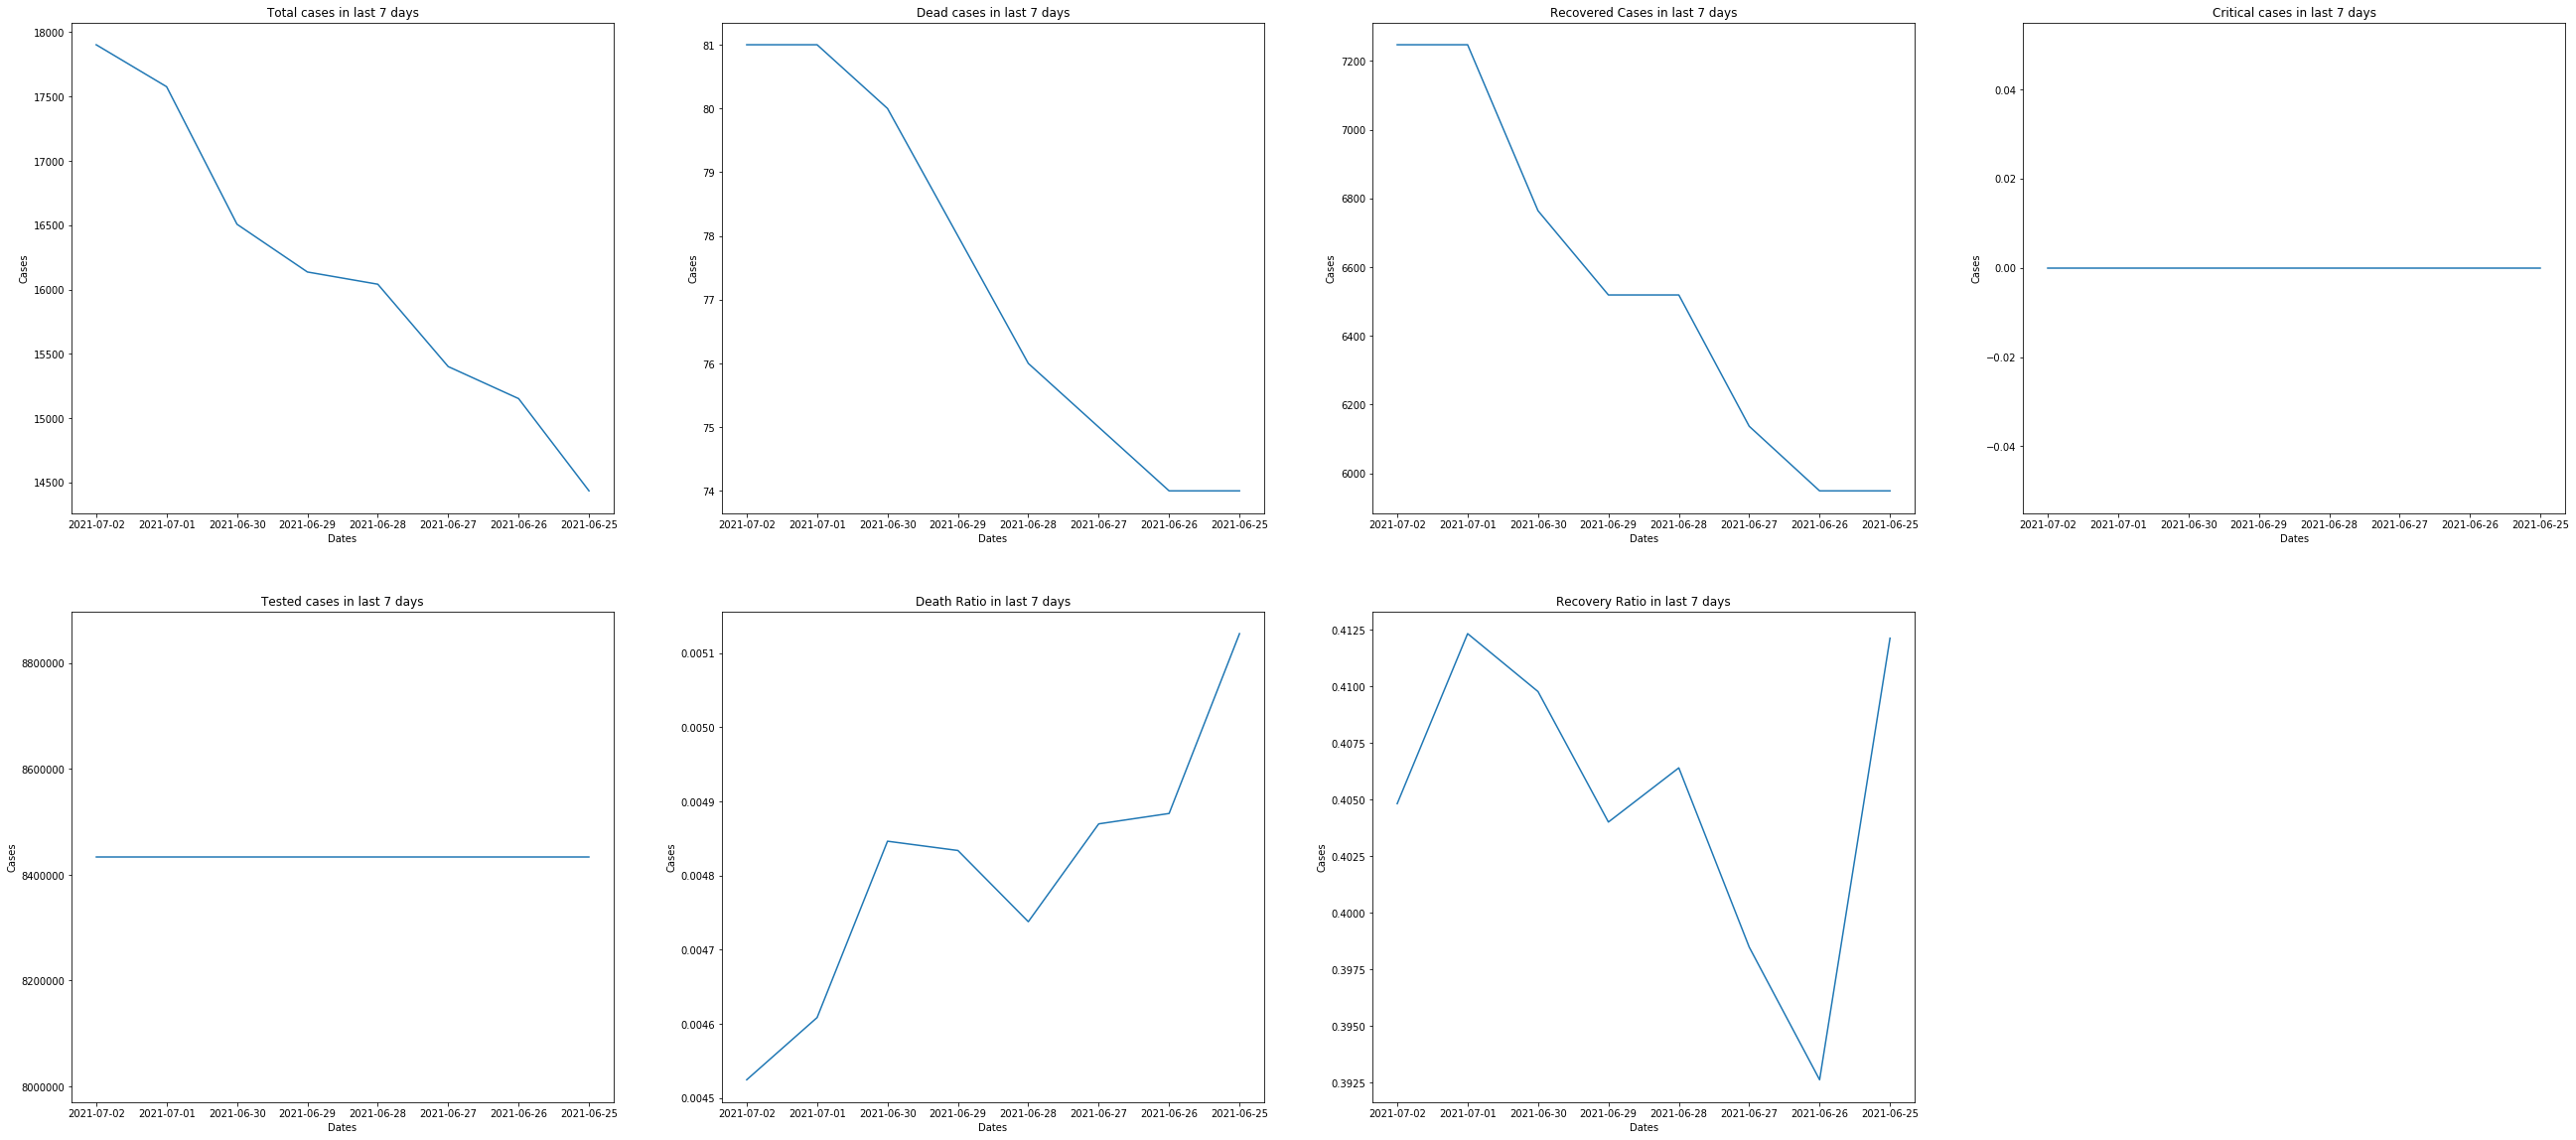

In [19]:
fig, axs = plt.subplots(2,4, figsize=(45, 20))
axs[0, 0].plot(list(week_data['total_cases'].keys()),list(week_data['total_cases'].values()))
axs[0, 0].set_title("Total cases in last 7 days")
axs[0, 1].plot(list(week_data['deaths'].keys()),list(week_data['deaths'].values()))
axs[0, 1].set_title("Dead cases in last 7 days")
axs[0, 2].plot(list(week_data['recovered'].keys()),list(week_data['recovered'].values()))
axs[0, 2].set_title("Recovered Cases in last 7 days")
axs[0, 3].plot(list(week_data['critical'].keys()),list(week_data['critical'].values()))
axs[0, 3].set_title("Critical cases in last 7 days")
axs[1, 0].plot(list(week_data['tested'].keys()),list(week_data['tested'].values()))
axs[1, 0].set_title("Tested cases in last 7 days")
axs[1, 1].plot(list(week_data['death_ratio'].keys()),list(week_data['death_ratio'].values()))
axs[1, 1].set_title("Death Ratio in last 7 days")
axs[1, 2].plot(list(week_data['recovery_ratio'].keys()),list(week_data['recovery_ratio'].values()))
axs[1, 2].set_title("Recovery Ratio in last 7 days")
fig.delaxes(axs[1,3]) 
for ax in axs.flat:
    ax.set(xlabel='Dates', ylabel='Cases')